In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

from holoinfer.model import hologram, math

from scipy import optimize
from scipy.special import expit

import holopy as hp
from holopy.core.process import bg_correct

Import test data:

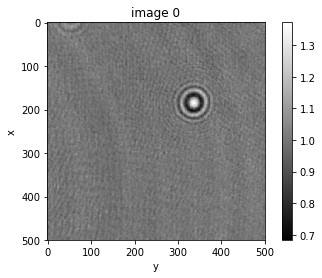

In [2]:
rholo = hp.core.load_image('exp_data_1/r_particle_0.png', channel=0, 
                          medium_index=1.33, spacing=0.0858, illum_polarization=(1,0), illum_wavelen=.660)

bgimg = ['exp_data_1/r_particle_bg_0.png', 'exp_data_1/r_particle_bg_1.png', 'exp_data_1/r_particle_bg_2.png']
bg = hp.core.io.load_average(bgimg, refimg = rholo, channel=0)
expholo = bg_correct(rholo, bg)
hp.show(expholo)

Generate a test hologram from the forward model

In [6]:
pixel_size = 0.0858 # All units are in microns
grid_size = int(np.sqrt(expholo.size))

illum_wavelength = .660
med_index = 1.33

sc_center = np.array([350*pixel_size, 200*pixel_size, 5])
sc_radius = .5
sc_index = 1.4734

illum_wavenumber = 2*np.pi/illum_wavelength
rel_index = np.array([sc_index/med_index, 0])

x = y = np.linspace(0, pixel_size*grid_size, grid_size)
z = 0
detector_grid = math.cartesian(x, y, z)

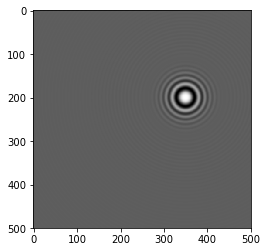

In [7]:
data = hologram.rayleigh_gans_sphere_holo(detector_grid, illum_wavenumber, sc_center, rel_index, sc_radius)
#data = math.add_noise(data)
plt.gray()
plt.imshow(data.reshape((grid_size,grid_size)))
plt.show()

Fit test data to model using pymc3 (wihich uses scipy.optimize)

In [8]:
with pm.Model() as RGScatterer:
    center = pm.Uniform('pos', lower=0, upper=0.0858*500, shape=3)
    
    index_real = pm.Normal('Re(m)', mu=1, sd=.1)
    index_imag = pm.HalfNormal('Im(m)', sd=.1)
    index = [index_real, index_imag]
    
    radius = pm.Uniform('Radius', lower=illum_wavelength/10, upper=illum_wavelength*10)
    
    expectedvalue = hologram.rayleigh_gans_sphere_holo(detector_grid, illum_wavenumber, center, index, radius)
    likelihood = pm.Normal('likelihood', mu=expectedvalue, observed=data)

In [9]:
with RGScatterer:
    map_estimate = pm.find_MAP()
map_estimate

INFO (theano.gof.compilelock): Refreshing lock C:\Users\Ron\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.1-64\lock_dir\lock
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Ron\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.1-64\lock_dir\lock
INFO (theano.gof.compilelock): Refreshing lock C:\Users\Ron\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-3.6.1-64\lock_dir\lock


         Current function value: 230232.008509
         Iterations: 8
         Function evaluations: 34
         Gradient evaluations: 25


{'Im(m)_log_': array(-129.7577385852398),
 'Radius_interval_': array(74.78667808732712),
 'Re(m)': array(1.501729506274626),
 'pos_interval_': array([ -37.70183714,   14.06635387, -180.35026055])}

In [27]:
np.exp(map_estimate['Im(m)_log_'])

4.4353729976731258e-57

In [33]:
expit(map_estimate['pos_interval_'])/pixel_size

array([  4.92961367e-16,   1.16550026e+01,   5.51302224e-78])

In [36]:
expit(map_estimate['Radius_interval_'])

1.0

Try again with different optimization method?

In [38]:
map_estimate_powell = pm.find_MAP(model=RGScatterer, fmin=optimize.fmin_powell)

Optimization terminated successfully.
         Current function value: 229793.852482
         Iterations: 2
         Function evaluations: 173


In [39]:
map_estimate_powell

{'Im(m)_log_': array(-2.5509216178328002),
 'Radius_interval_': array(-3.8362619657790296),
 'Re(m)': array(0.9999368882325018),
 'pos_interval_': array([-0.39799712,  0.00583566, -0.03339756])}

In [40]:
expit(map_estimate_powell['pos_interval_'])/pixel_size

array([ 4.68290964,  5.84450945,  5.73020263])

In [41]:
expit(map_estimate_powell['Radius_interval_'])

0.02111848333708145

In [42]:
np.exp(map_estimate_powell['Im(m)_log_'])

0.078009737695647452

Try with optimize.curve_fit

MCMC Calculations:

In [ ]:
with RGScatterer:
    start = pm.find_MAP()
    #step = pm.NUTS() #advi before this?
    #trace = pm.sample(64, step=step, start=start)
    trace = pm.sample(64, start = start)

In [ ]:
pm.traceplot(trace)

In [ ]:
nuts_center = trace.get_values('Scatterer location').mean(axis=0)
print(nuts_center)
#nuts_n = trace.get_values('N').mean()
#print(nuts_n)

Below is the original hologram, the hologram with noise added (raw data), and a "reconstructed" hologram calculated from parameters inferred by pymc3 from the noisy hologram.

In [ ]:
#plt.subplot(1, 3, 1)
#plt.imshow(clean_data.reshape((resolution, resolution)))
#plt.subplot(1, 3, 2)
#plt.imshow(data.reshape((resolution, resolution)))
#plt.subplot(1, 3, 3)
#plt.imshow(point_holo(grid, nuts_center, wavevector, nuts_n).reshape(resolution, resolution))
#plt.show()